#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from Spectra_Preparation_Functions import *

Read the spectral data

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")

In [3]:
df = df[(df['WaveNumber'] >= 400) & (df['WaveNumber'] <= 1800)]

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [5]:
# # Best Full Spectrum Parameters

# lam = 10 ** 7
# p = 0.05
# window_size = 51
# poly_order = 2

# Best 400-1800 Parameters

# lam = 10 ** 8
# p = 0.01
# window_size = 51
# poly_order = 3

# Standard Parameters
despike_ma = 25
despike_threshold = 3.75
lam = 10 ** 5
p = 0.001
window_size = 21
poly_order = 2

# More parameters from optuna
# despike_ma = 19
# despike_threshold = 5.75
# lam = 10**10
# p = 0.049

# Clean Params for Pagerank weights
# despike_ma = 19
# despike_threshold = 5.75
# lam = 10**8
# p = 0.049
# window_size = 11
# poly_order = 2

# pagerank_cutoff = 0.902461
# despike_ma = 57
# despike_threshold = 3.75
# lam = 10 ** 11
# p = 0.074
# window_size = 51
# poly_order = 3

#### **Here is an example on 1 spectrum**

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

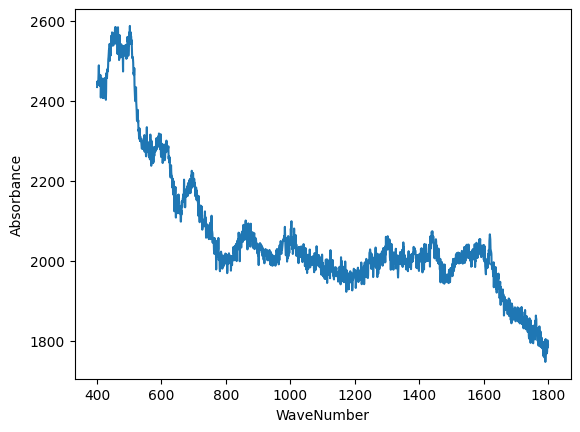

In [6]:
sample = df[df['SpecID'] == "201210-1-07"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_29672\2465510453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

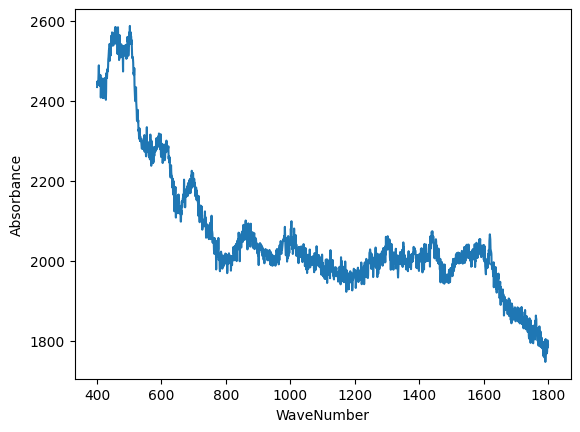

In [7]:
sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_29672\3348993900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

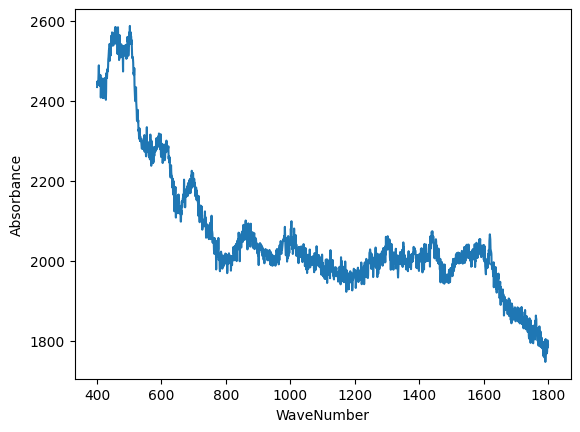

In [8]:
sample['Despiked_Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_29672\742450235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


<AxesSubplot: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

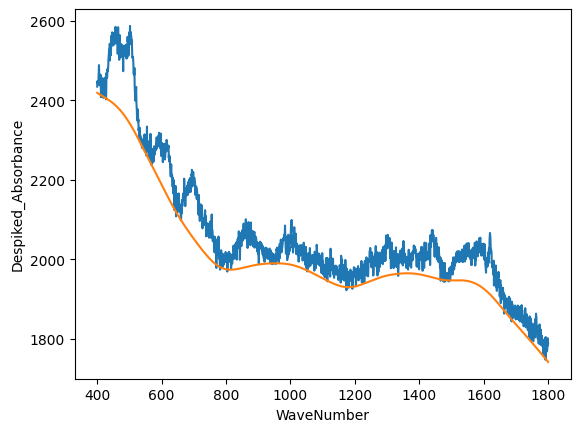

In [9]:
sample['Baseline'] = sample.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)

Subtract the baseline.

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_29672\1303904700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

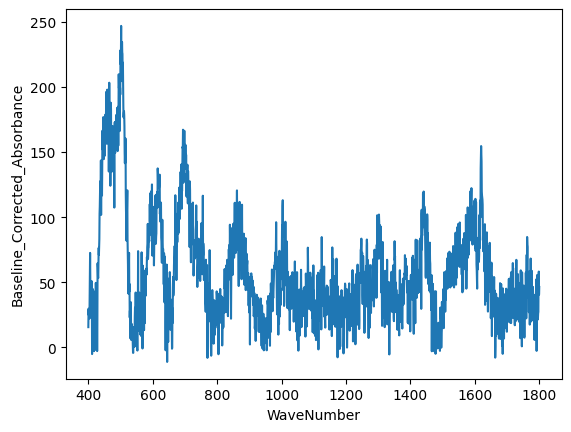

In [10]:
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Smooth the Baseline_Corrected_Spectrum

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_29672\1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

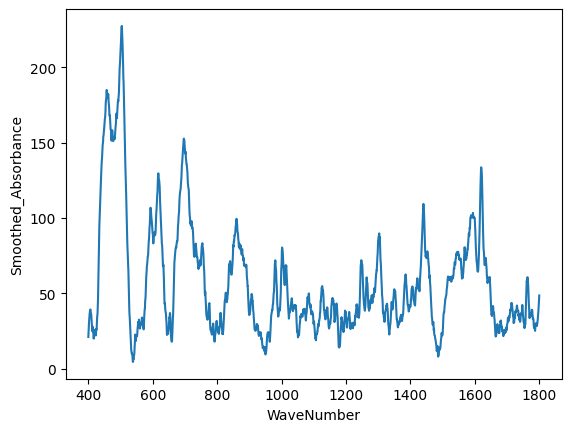

In [11]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

In [12]:
# # Despike

df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [13]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))

In [14]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df['Baseline']

In [15]:
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [16]:
# Optional Scaling
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: normalise(x))
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: vector_normalise(x))
# df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Smooth_Baseline_Corrected'].transform(lambda x: svn_normalise(x))

In [17]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
293,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1738.533914,27.128886,0.010818
294,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1738.111245,36.669655,0.010550
295,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1737.688577,31.341623,0.010328
296,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1737.265910,19.156090,0.010151
297,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1736.843244,22.025756,0.010019
...,...,...,...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1595.984438,21.408162,0.013431
8023278,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1595.024463,38.066637,0.013375
8023279,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1594.064491,39.243109,0.013260
8023280,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1593.104520,48.761980,0.013085


In [18]:
df = df.drop(columns=['Absorbance', 'Baseline', 'Baseline_Corrected_Absorbance'])
df = df.rename(columns={'Smooth_Baseline_Corrected':'Absorbance'})

In [19]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
293,201210-1-00,293,400.22778,201210-1,Normal,0.010818
294,201210-1-00,294,400.91116,201210-1,Normal,0.010550
295,201210-1-00,295,401.59454,201210-1,Normal,0.010328
296,201210-1-00,296,402.27789,201210-1,Normal,0.010151
297,201210-1-00,297,402.96127,201210-1,Normal,0.010019
...,...,...,...,...,...,...
8023277,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,0.013431
8023278,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,0.013375
8023279,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,0.013260
8023280,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,0.013085


In [20]:
df.to_csv("../../data/standard_cleaning.csv", index=False)
#df.to_csv("../../data/current_clean_spectrum.csv", index=False)
# df.to_csv("../../data/400-1800_spike_removed.csv", index=False)